# CNN

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

Convolutional neural network (CNN) is a regularized type of feed-forward neural network that learns feature engineering by itself via filters (or kernel) optimization. Vanishing gradients and exploding gradients, seen during backpropagation in earlier neural networks, are prevented by using regularized weights over fewer connections. For example, for each neuron in the fully-connected layer 10,000 weights would be required for processing an image sized 100 × 100 pixels. However, applying cascaded convolution (or cross-correlation) kernels, only 25 neurons are required to process 5x5-sized tiles. Higher-layer features are extracted from wider context windows, compared to lower-layer features.

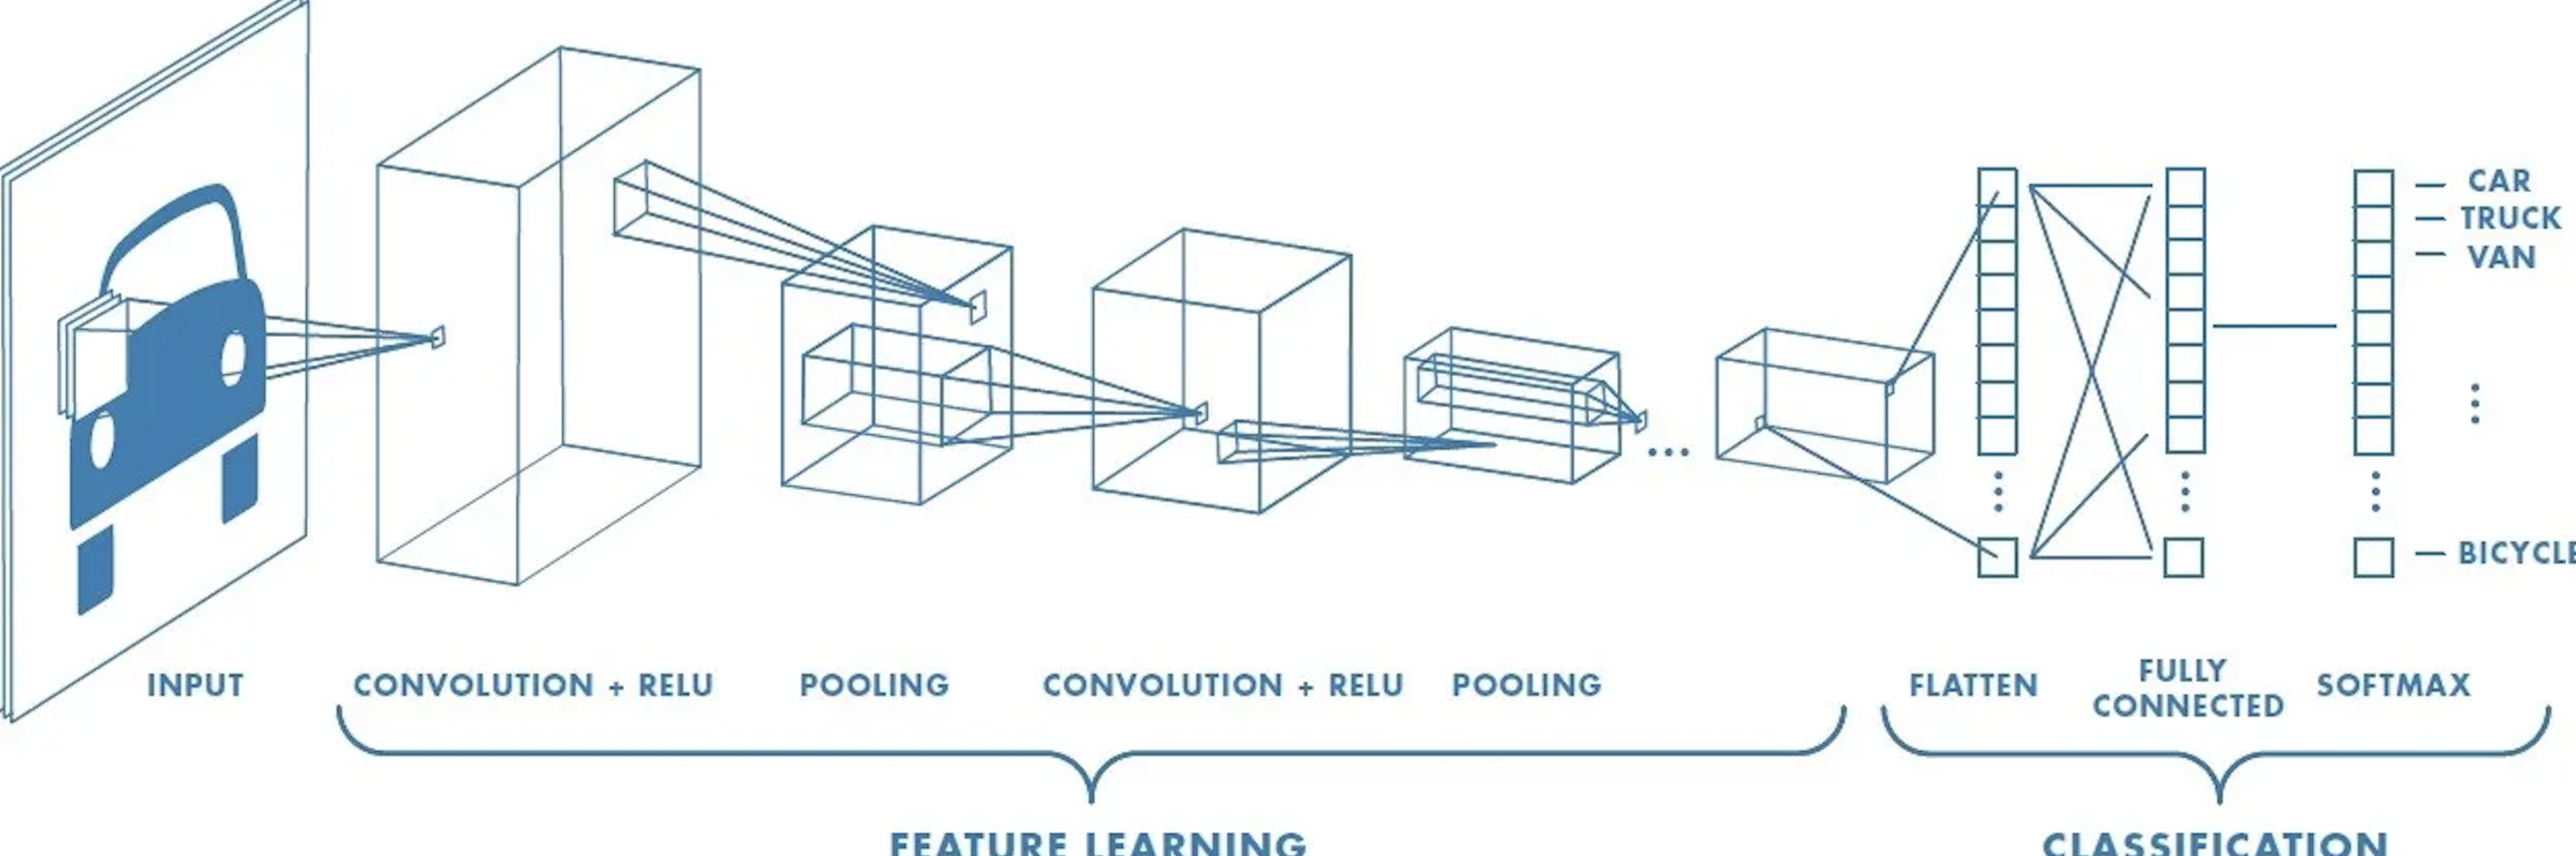

**Sride:** Stride is a parameter that dictates the movement of the kernel, or filter, across the input data, such as an image. When performing a convolution operation, the stride determines how many units the filter shifts at each step. This shift can be horizontal, vertical, or both, depending on the stride's configuration.

For example, a stride of 1 moves the filter one pixel at a time, while a stride of 2 moves it two pixels. A larger stride will produce a smaller output dimension, effectively downsampling the image.

**Padding:** Padding in CNN refers to the addition of extra pixels around the borders of the input images or feature map.

**Data Type at Entry:** Array.

**Data Type at Output:** Array.

### Formula

$ output = floor[(n_h - k_h + 2 \cdot p_h + s_h)/s_h] \times floor[(n_w - k_w + 2 \cdot p_w + s_w)/s_w] $

$ n: $ dimension.

$ k: $ kernel size.

$ p: $ padding.

$ s: $ stride.

In [1]:
import time
import torch
import keras
import numpy as np
import pandas as pd
import torch.nn as nn
from keras.layers import Dense
from keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

# 1. Import Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import time
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from PIL import Image, ImageOps
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# 2. Functions

In [5]:
def resize_image(src_image, size=(128,128), bg_color="white"):

    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)

    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)

    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))

    # return the resized image
    return new_image

In [6]:
def print_time_execution(start, end, text):

    delta = (end - start)

    hours = int(delta/3600)
    mins = int((delta - hours*3600)/60)
    segs = int(delta - hours*3600 - mins*60)
    return f'Execute {text} take us {hours} hours, {mins} minutes and {segs} seconds.'

### Start time of execution

In [7]:
start = time.time()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train_folder = 'drive/MyDrive/Github_Alberto_Valdes/Deep_Learning/CNN/working/natural_images'

img_size = (128,128)

classes = sorted(os.listdir(train_folder))
print(classes)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


# 3. Data Loader

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

In [11]:
def load_dataset(data_path):

    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0, 0, 0], std = [1, 1, 1])
    ])

    full_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transformation
    )

    # Split

    train_size = int(0.7 * len(full_dataset))
    test_size = int(len(full_dataset) - train_size)

    new_test_size = int(test_size/2)
    new_val_size = int(test_size - new_test_size)

    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [new_val_size, new_test_size])

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size = 50,
        num_workers = 0,
        shuffle = False
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size = 50,
        num_workers = 0,
        shuffle = False
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = 50,
        num_workers = 0,
        shuffle = False
    )

    return train_loader, val_loader, test_loader

In [12]:
data_path = train_folder

In [13]:
train_loader, val_loader, test_loader = load_dataset(data_path)

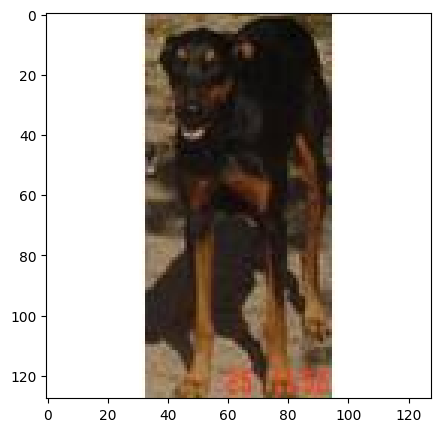

In [14]:
plt.figure(figsize = (5, 5))
plt.imshow(train_loader.dataset[0][0].permute(1, 2, 0))
plt.show()

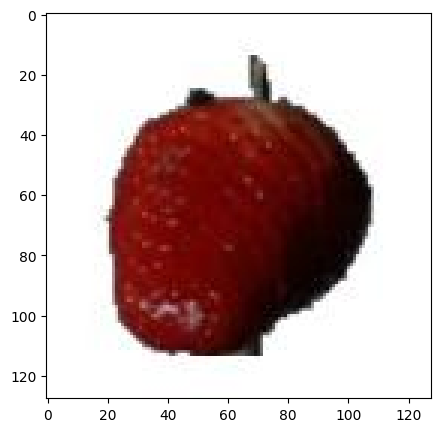

In [15]:
plt.figure(figsize = (5, 5))
plt.imshow(train_loader.dataset[3][0].permute(1, 2, 0))
plt.show()

# 4. Neural Network and Data

In [16]:
keras.backend.set_image_data_format('channels_first')

In [17]:
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Softmax
from keras.layers import Activation
from keras.layers import MaxPooling2D
from tensorflow.keras import activations

from keras.optimizers import Adam

In [18]:
def data_loader_to_numpy(data_loader):

  X = []
  y = []

  start_batch = time.time()

  for batch_idx, (data, target) in enumerate(data_loader):

    print('Batch:', batch_idx)

    data_a = data.numpy()
    target_a = target.numpy()

    target_0 = (target_a == 0)*1
    target_1 = (target_a == 1)*1
    target_2 = (target_a == 2)*1
    target_3 = (target_a == 3)*1
    target_4 = (target_a == 4)*1
    target_5 = (target_a == 5)*1
    target_6 = (target_a == 6)*1
    target_7 = (target_a == 7)*1

    target_b = np.array([target_0, target_1, target_2, target_3, target_4, target_5, target_6, target_7])
    target_c = np.transpose(target_b)

    if len(X) == 0:

      X = data_a.copy()
      y = target_c.copy()

    else:

      X = np.concatenate((X, data_a.copy()), axis = 0)
      y = np.concatenate((y, target_c.copy()), axis = 0)

    end_batch = time.time()
    print(print_time_execution(start_batch, end_batch, f'batch = {batch_idx}'))
    start_batch = time.time()
    print('-'*70)

  return X, y

In [19]:
X_train, y_train = data_loader_to_numpy(train_loader)

Batch: 0
Execute batch = 0 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 1
Execute batch = 1 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 2
Execute batch = 2 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 3
Execute batch = 3 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 4
Execute batch = 4 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 5
Execute batch = 5 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 6
Execute batch = 6 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 7
Execute bat

In [20]:
X_val, y_val = data_loader_to_numpy(val_loader)

Batch: 0
Execute batch = 0 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 1
Execute batch = 1 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 2
Execute batch = 2 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 3
Execute batch = 3 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 4
Execute batch = 4 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 5
Execute batch = 5 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 6
Execute batch = 6 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 7
Execute bat

In [21]:
X_test, y_test = data_loader_to_numpy(test_loader)

Batch: 0
Execute batch = 0 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 1
Execute batch = 1 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 2
Execute batch = 2 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 3
Execute batch = 3 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 4
Execute batch = 4 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 5
Execute batch = 5 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 6
Execute batch = 6 take us 0 hours, 0 minutes and 0 seconds.
----------------------------------------------------------------------
Batch: 7
Execute bat

In [22]:
model = Sequential()

model.add(Conv2D(filters = 12, kernel_size = 3, strides = (1, 1), padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation(activations.relu))

model.add(Conv2D(filters = 24, kernel_size = 3, strides = (1, 1), padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Activation(activations.relu))

model.add(Dropout(rate = 0.2))

model.add(Flatten())

model.add(Dense(len(classes)))

model.add(Softmax())

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy')

# 5. Training

In [23]:
n_epochs = 20

In [24]:
hist = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 50, epochs = n_epochs, verbose = 1)

Epoch 1/20
97/97 [==============================] - 8s 33ms/step - loss: 0.7253 - val_loss: 0.3283
Epoch 2/20
97/97 [==============================] - 1s 13ms/step - loss: 0.2828 - val_loss: 0.2988
Epoch 3/20
97/97 [==============================] - 1s 14ms/step - loss: 0.2018 - val_loss: 0.2282
Epoch 4/20
97/97 [==============================] - 2s 17ms/step - loss: 0.1723 - val_loss: 0.2123
Epoch 5/20
97/97 [==============================] - 2s 16ms/step - loss: 0.1341 - val_loss: 0.2724
Epoch 6/20
97/97 [==============================] - 2s 16ms/step - loss: 0.1211 - val_loss: 0.2010
Epoch 7/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0915 - val_loss: 0.2095
Epoch 8/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0803 - val_loss: 0.2114
Epoch 9/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0759 - val_loss: 0.2392
Epoch 10/20
97/97 [==============================] - 1s 14ms/step - loss: 0.0531 - val_loss: 0.1956
Epoch 11/

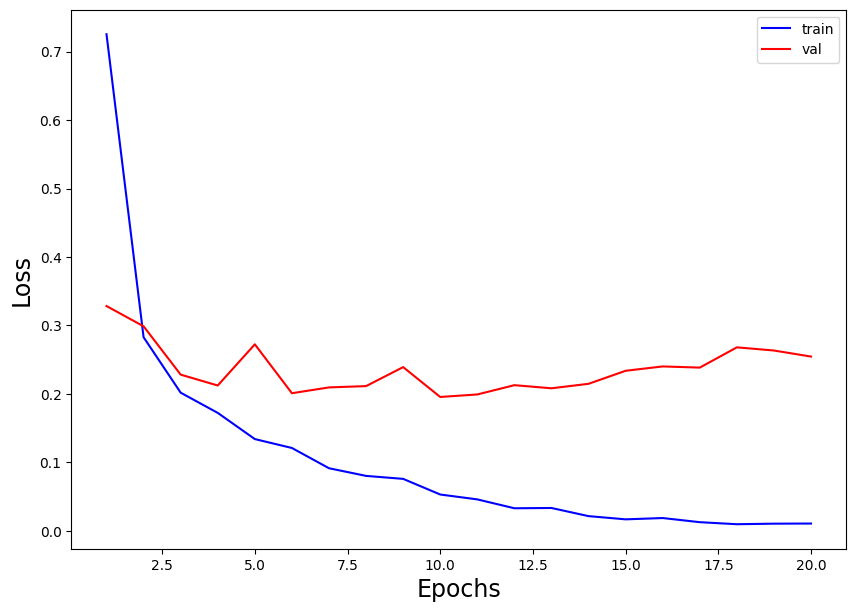

In [25]:
plt.figure(figsize = (10, 7))

plt.plot([i for i in range(1, n_epochs + 1)], hist.history['loss'], color = 'blue', label = 'train')
plt.plot([i for i in range(1, n_epochs + 1)], hist.history['val_loss'], color = 'red', label = 'val')

plt.xlabel('Epochs', fontsize = 17)
plt.ylabel('Loss', fontsize = 17)

plt.legend()
plt.show()

# 6. Performance

In [26]:
out_train = model(X_train).numpy()

In [27]:
accu_train = round((out_train.argmax(axis = 1) == y_train.argmax(axis = 1)).sum()/len(y_train)*100, 2)

In [28]:
accu_train

100.0

In [29]:
out_val = model(X_val).numpy()

In [30]:
accu_val = round((out_val.argmax(axis = 1) == y_val.argmax(axis = 1)).sum()/len(y_val)*100, 2)

In [31]:
accu_val

91.69

In [32]:
out_test = model(X_test).numpy()

In [33]:
accu_test = round((out_test.argmax(axis = 1) == y_test.argmax(axis = 1)).sum()/len(y_test)*100, 2)

In [34]:
accu_test

91.4

# 7. Test

In [35]:
def test_image(ind):

  plt.figure(figsize = (5, 5))
  plt.imshow(X_test[ind].transpose((1, 2, 0)))
  plt.show()

  print(pd.DataFrame(zip(np.round(out_test[ind]*100, 2), classes)))

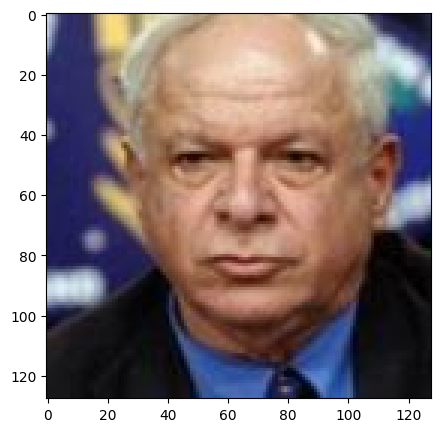

       0          1
0    0.0   airplane
1    0.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5    0.0      fruit
6    0.0  motorbike
7  100.0     person


In [36]:
test_image(0)

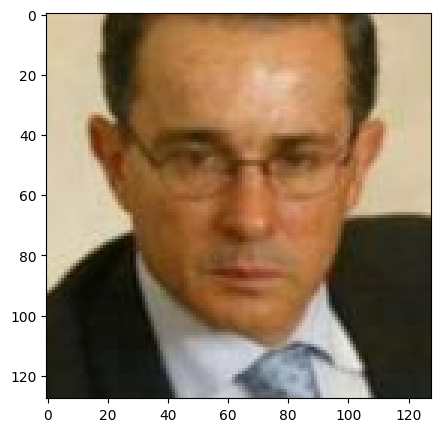

       0          1
0    0.0   airplane
1    0.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5    0.0      fruit
6    0.0  motorbike
7  100.0     person


In [37]:
test_image(100)

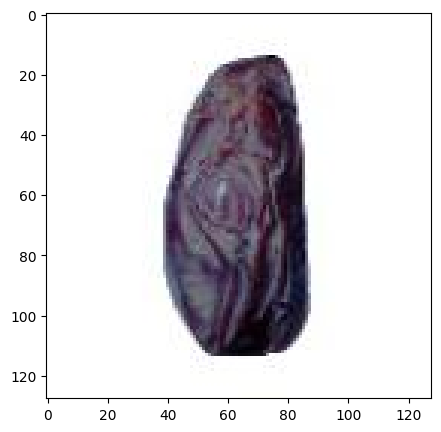

       0          1
0    0.0   airplane
1    0.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5  100.0      fruit
6    0.0  motorbike
7    0.0     person


In [38]:
test_image(200)

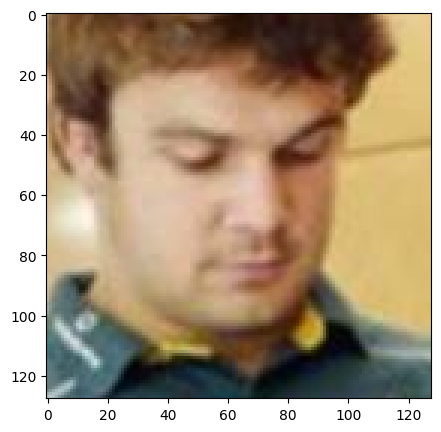

           0          1
0   0.000000   airplane
1   0.000000        car
2   0.000000        cat
3   0.010000        dog
4   0.000000     flower
5   0.000000      fruit
6   0.000000  motorbike
7  99.989998     person


In [39]:
test_image(300)

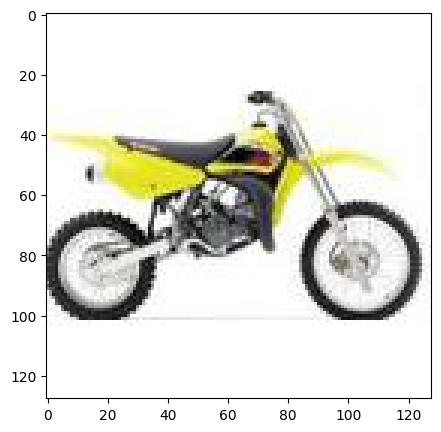

       0          1
0    0.0   airplane
1    0.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5    0.0      fruit
6  100.0  motorbike
7    0.0     person


In [40]:
test_image(400)

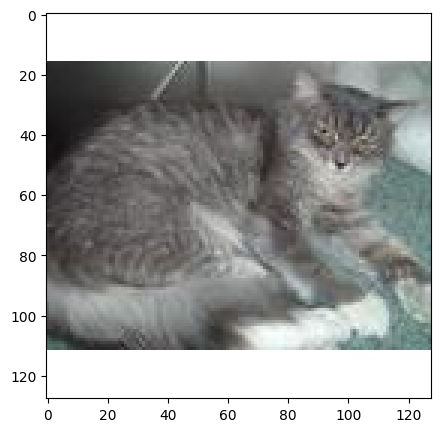

           0          1
0   0.000000   airplane
1   0.000000        car
2  91.629997        cat
3   8.370000        dog
4   0.000000     flower
5   0.000000      fruit
6   0.000000  motorbike
7   0.000000     person


In [41]:
test_image(500)

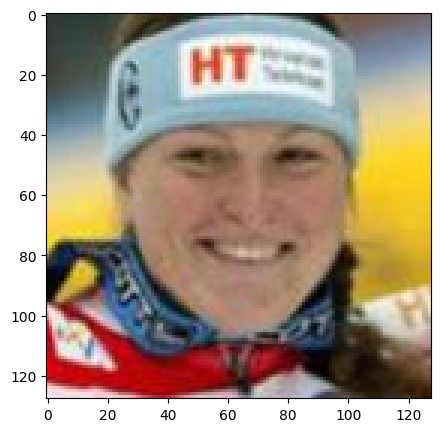

       0          1
0    0.0   airplane
1    0.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5    0.0      fruit
6    0.0  motorbike
7  100.0     person


In [42]:
test_image(600)

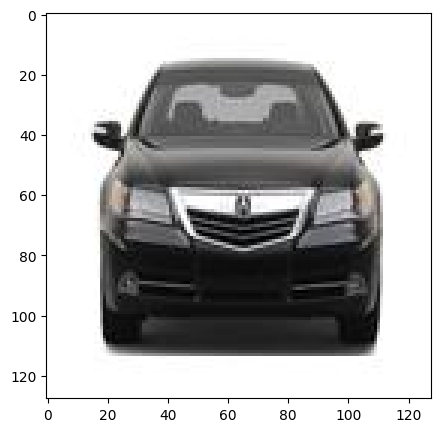

       0          1
0    0.0   airplane
1  100.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5    0.0      fruit
6    0.0  motorbike
7    0.0     person


In [43]:
test_image(700)

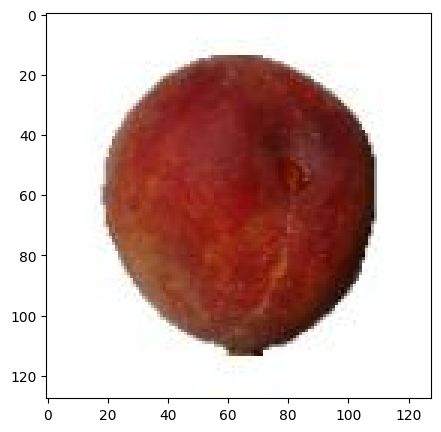

       0          1
0    0.0   airplane
1    0.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5  100.0      fruit
6    0.0  motorbike
7    0.0     person


In [44]:
test_image(800)

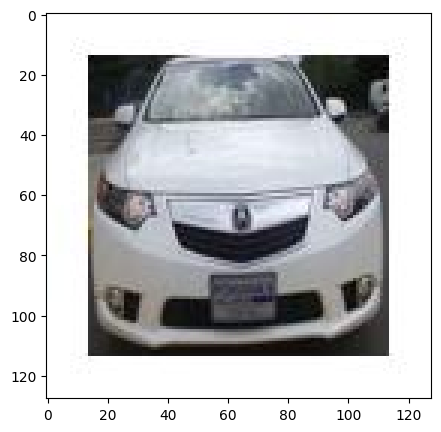

       0          1
0    0.0   airplane
1  100.0        car
2    0.0        cat
3    0.0        dog
4    0.0     flower
5    0.0      fruit
6    0.0  motorbike
7    0.0     person


In [45]:
test_image(900)

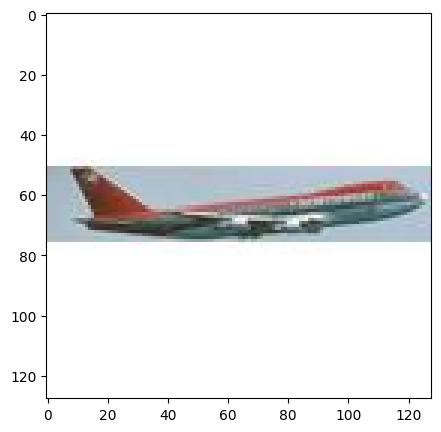

           0          1
0  99.989998   airplane
1   0.000000        car
2   0.000000        cat
3   0.010000        dog
4   0.000000     flower
5   0.000000      fruit
6   0.000000  motorbike
7   0.000000     person


In [46]:
test_image(1_000)

In [47]:
cm = confusion_matrix(y_test.argmax(axis = 1), out_test.argmax(axis = 1))

In [48]:
df_cm = pd.DataFrame(cm, index = classes, columns = classes)

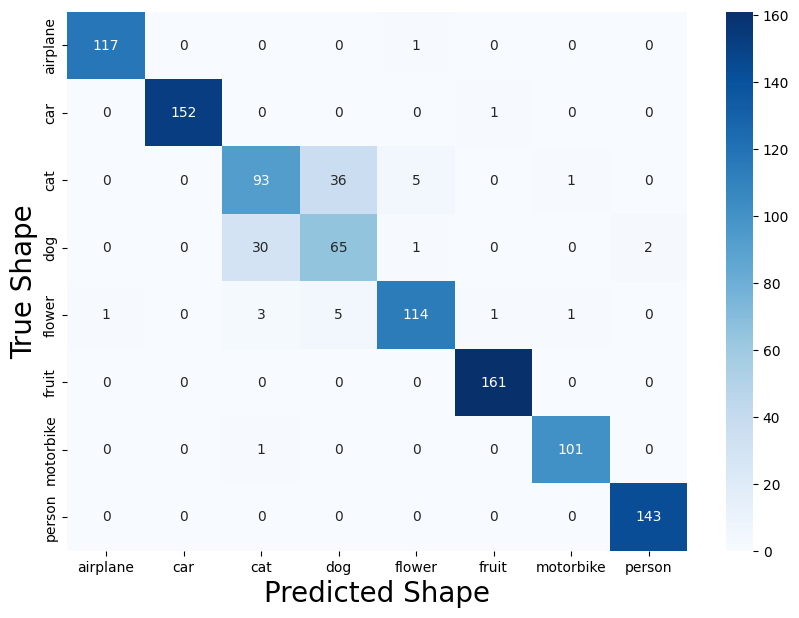

In [49]:
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot = True, cmap = plt.cm.Blues, fmt = 'g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

### End time of execution

In [50]:
end = time.time()

In [51]:
print(print_time_execution(start, end, 'this notebook'))

Execute this notebook take us 0 hours, 1 minutes and 58 seconds.
